In [1]:
import matplotlib.pyplot as plt

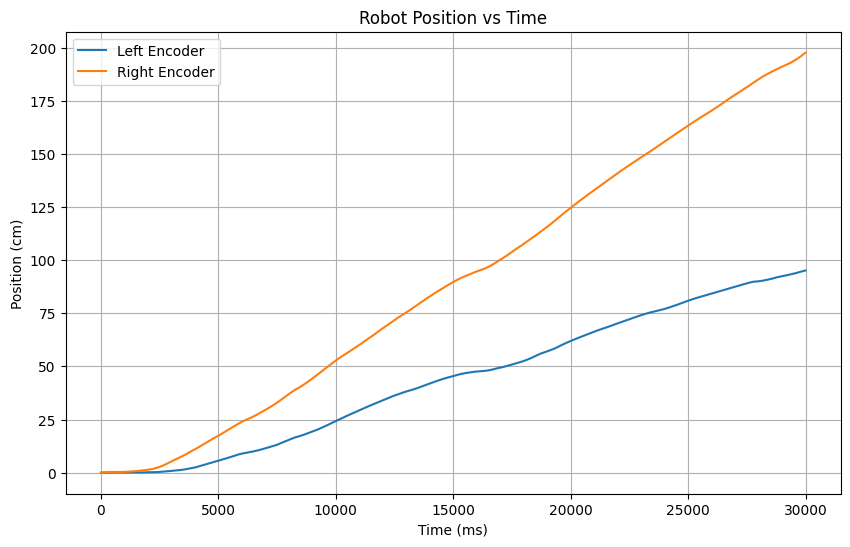

In [4]:
with open('data.csv', 'r') as f:
    data = f.readlines()

# Parse the data into lists
times = []
left_positions = []
right_positions = []

for line in data:
    t, left, right = line.strip().split(',')
    times.append(float(t))
    left_positions.append(float(left))
    right_positions.append(float(right))

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(times, left_positions, label='Left Encoder')
plt.plot(times, right_positions, label='Right Encoder')
plt.xlabel('Time (ms)')
plt.ylabel('Position (cm)')
plt.title('Robot Position vs Time')
plt.legend()
plt.grid(True)
plt.show()

